In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import cv2
from random import shuffle
import h5py
from shutil import copy,move
labels = pd.read_csv('train_labels.csv')
names = labels['name']
inv = labels['invasive']

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [59]:
inv[50]

0

In [51]:
def func():
    folder = 'train'
    
    for i in tqdm.tqdm(range(len(names))):
        val_folds = os.path.join('train',str(names[i]) + '.jpg')
        if inv[i] == 1:
            copy(val_folds,os.path.join('Images','1'))
        else:
                 copy(val_folds,os.path.join('Images','0'))
          
func()

100%|██████████| 2295/2295 [00:02<00:00, 855.52it/s] 


In [58]:
os.makedirs('val')
def val():
   
    for folder in os.listdir('Images'):
        print(folder)
        os.makedirs(os.path.join('val',folder))
        new = os.path.join('val',folder)
        
        i = 0
        folder = os.path.join('Images',folder)
        print(folder)
        for file in os.listdir(folder):
            print(file)
            file = os.path.join(folder,file)
            move(file,new)
            i = i+1
            if i == 125:
                break
                        
val()

1
Images/1
120.jpg
1565.jpg
1702.jpg
1569.jpg
2131.jpg
315.jpg
2135.jpg
324.jpg
988.jpg
81.jpg
1943.jpg
2016.jpg
1387.jpg
1708.jpg
1751.jpg
1144.jpg
1158.jpg
808.jpg
614.jpg
714.jpg
2221.jpg
1220.jpg
777.jpg
1721.jpg
1574.jpg
973.jpg
904.jpg
2148.jpg
1245.jpg
1030.jpg
1792.jpg
479.jpg
23.jpg
512.jpg
321.jpg
1423.jpg
1869.jpg
169.jpg
814.jpg
2133.jpg
617.jpg
1241.jpg
1128.jpg
1178.jpg
2219.jpg
964.jpg
1199.jpg
2254.jpg
1317.jpg
671.jpg
1962.jpg
672.jpg
1739.jpg
1411.jpg
1035.jpg
580.jpg
1679.jpg
1915.jpg
1798.jpg
1243.jpg
822.jpg
894.jpg
689.jpg
264.jpg
706.jpg
1555.jpg
76.jpg
1690.jpg
955.jpg
1749.jpg
2216.jpg
1499.jpg
1990.jpg
1897.jpg
2181.jpg
668.jpg
1238.jpg
1398.jpg
396.jpg
191.jpg
1399.jpg
1063.jpg
1424.jpg
273.jpg
1775.jpg
2177.jpg
1154.jpg
717.jpg
1263.jpg
1215.jpg
1075.jpg
527.jpg
99.jpg
710.jpg
1428.jpg
1406.jpg
2165.jpg
1604.jpg
801.jpg
1706.jpg
2259.jpg
397.jpg
825.jpg
1129.jpg
1335.jpg
1747.jpg
1118.jpg
2288.jpg
1628.jpg
960.jpg
1431.jpg
233.jpg
1446.jpg
444.jpg
2003.jpg
7

In [2]:
def save(model):

    model_save = model.to_json()
    with open("weights70.json","w") as json_file:
        json_file.write(model_save)

    model.save_weights("model70.h5")
    print("SAVED")



In [3]:
from keras.layers import Dense,Conv2D
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
import math

Using TensorFlow backend.


In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
    rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'Images',
        shuffle = False,
        target_size=(300,400),
        batch_size=5,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'val',
        shuffle = False,
        target_size=(300,400),
        batch_size=5,
        class_mode='categorical')


Found 1920 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Activation,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.utils import np_utils
import math

In [6]:
vgg_model = VGG16(weights = 'imagenet',include_top = False,input_shape = (300,400,3))

In [109]:
bnf_train = vgg_model.predict_generator(train_generator)
bnf_val = vgg_model.predict_generator(validation_generator)

In [110]:
print(bnf_train.shape)

(1920, 9, 12, 512)


In [111]:
bnf_val.shape

(250, 9, 12, 512)

In [112]:
np.save('bnf_train.npy',bnf_train)
np.save('bnf_val.npy',bnf_val)


In [113]:
model = Sequential()  
model.add(Flatten(input_shape=bnf_train.shape[1:]))  
model.add(Dense(256, activation='relu'))  
#model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(2, activation='sigmoid'))  

In [13]:
Y = train_generator.classes
print(Y)
Y_val = validation_generator.classes
print(Y.shape)
Y = np_utils.to_categorical(Y)
Y_val = np_utils.to_categorical(Y_val)

print(Y)
print(Y_val.shape)

[0 0 0 ... 1 1 1]
(1920,)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
(250, 2)


In [115]:
rms = RMSprop(lr = 0.0001)
model.compile(loss = 'categorical_crossentropy',optimizer = rms , metrics = ['accuracy'])

In [130]:
hist = model.fit(bnf_train,Y,epochs=30, batch_size=300,validation_data = (bnf_val,Y_val))

Train on 1920 samples, validate on 250 samples
Epoch 1/30
1920/1920 [==============================] - 0s 204us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 1.0000
Epoch 2/30
1920/1920 [==============================] - 0s 206us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 1.0000
Epoch 3/30
1920/1920 [==============================] - 0s 205us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 0.9960
Epoch 4/30
1920/1920 [==============================] - 0s 208us/step - loss: 0.0010 - acc: 0.9995 - val_loss: 0.0189 - val_acc: 0.9960
Epoch 5/30
1920/1920 [==============================] - 0s 207us/step - loss: 9.0172e-04 - acc: 0.9995 - val_loss: 0.0215 - val_acc: 0.9960
Epoch 6/30
1920/1920 [==============================] - 0s 214us/step - loss: 7.9812e-04 - acc: 0.9995 - val_loss: 0.0239 - val_acc: 0.9960
Epoch 7/30
1920/1920 [==============================] - 0s 209us/step - loss: 7.2982e-04 - acc: 1.0000 - val_loss: 0.0200 - val_a

In [133]:
save(model)

SAVED


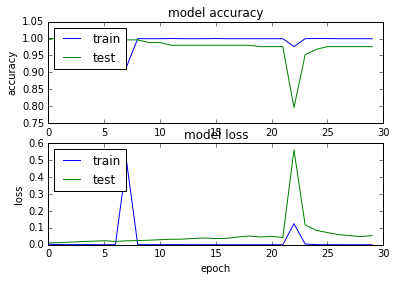

In [132]:
import matplotlib.pyplot as plt
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(hist.history['acc'])  
plt.plot(hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(hist.history['loss'])  
plt.plot(hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [7]:
from keras.models import model_from_json

load_json = open("weights70.json",'r')
loaded = load_json.read()
load_json.close()
load = model_from_json(loaded)
load.load_weights("model70.h5")
print("Loaded")
model = load

Loaded


In [8]:
class_dictionary = train_generator.class_indices 
inv_map = {v: k for k, v in class_dictionary.items()}  

In [14]:
import cv2
import numpy as np
file_names = []
final = []

for file in os.listdir('test'):
    name = os.path.join('test',file)
    img = load_img(name, target_size=(300,400))  
    img = img_to_array(img)  
    img = img/255
    img = np.expand_dims(img, axis=0)  
    b = vgg_model.predict(img)
    ans = model.predict(b)
    ans = np.argmax(ans)
    name = file.split('.')
    x = name[0]
    final.append(inv_map[ans])
    file_names.append(int(x))

In [15]:
import pandas as pd

df = pd.DataFrame(data={'name': file_names, 'invasive': final})
df_sort = df.sort_values(by=['name'])
df_sort.to_csv('results2.csv', index=False)